# Sucrose-Inversion Kinetics (CEU) Lab for CBE 154
Presented by Group MW1: Rahil Shaik, Sneha Kancharla, Alex Quemuel, Ethan Mibu

### Glucose Standard Results

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, root_scalar

In [184]:
df_stand = pd.read_csv("glucose-standard-res.csv")
df_stand

,Concentration of Reagent (g/L),Absorbance
0,0.02,0.52182
1,0.04,0.85720
2,0.06,1.03990
3,0.08,1.24860


##### our cuvette has a path length of 1 cm, so let's convert our concentration to units of cm^3

In [185]:
df_stand["Concentration (g/cm^3)"] = df_stand["Concentration of Reagent (g/L)"] * (1/1000)
df_stand

,Concentration of Reagent (g/L),Absorbance,Concentration (g/cm^3)
0,0.02,0.52182,0.00002
1,0.04,0.85720,0.00004
2,0.06,1.03990,0.00006
3,0.08,1.24860,0.00008


##### Now adjusting the absoprtion with the DI water baseline
##### $$ A_{\text{glucose,adj}} = A_{\text{glucose}} - A_{\text{DIW}}$$

In [186]:
A_DI1 = 0.1256 # DI Water Baseline Absorbance Day 1
A_DI2 = 0.13629 # DI Water Baseline Absorbance Day 2

df_stand["Absorbance adjusted"] = df_stand["Absorbance"].apply(lambda x: x - A_DI1)
df_stand

,Concentration of Reagent (g/L),Absorbance,Concentration (g/cm^3),Absorbance adjusted
0,0.02,0.52182,0.00002,0.39622
1,0.04,0.85720,0.00004,0.73160
2,0.06,1.03990,0.00006,0.91430
3,0.08,1.24860,0.00008,1.12300


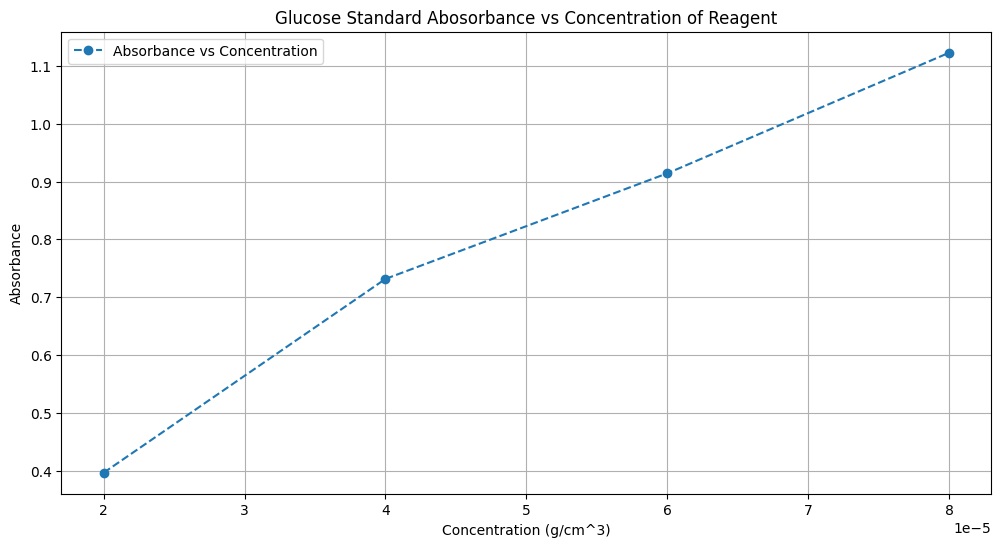

In [187]:
plt.figure(figsize=(12,6))
plt.plot(df_stand["Concentration (g/cm^3)"], df_stand["Absorbance adjusted"], label = "Absorbance vs Concentration",  marker= "o", linestyle="--")
plt.xlabel("Concentration (g/cm^3)")
plt.ylabel("Absorbance")
plt.title("Glucose Standard Abosorbance vs Concentration of Reagent")
plt.grid()
plt.legend()

plt.show()

### CEU Glucose Product Results

Note that all temperature recordings are in Celisus

In [188]:
df_res = pd.read_csv("CEU-glucose-results.csv")
df_res.query("Temperature == 50")

,Day,Type,Temperature,Absorbance,Sample
0,1,1,50,1.4619,1
1,1,1,50,1.5242,2
2,1,1,50,1.5791,3
9,2,2,50,1.6128,1
10,2,2,50,1.6304,2
11,2,2,50,1.6542,3


In [189]:
def adjust_absorbance(day, absorbance, A_DI1, A_DI2):
    if day == 1:
        return absorbance - A_DI1
    elif day == 2:
        return absorbance - A_DI2
    else:
        raise ValueError("Invalid day value")
    
df_res["Absorbance adjusted"] = df_res.apply(lambda x: adjust_absorbance(x["Day"], x["Absorbance"], A_DI1, A_DI2), axis=1)

df_res

,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted
0,1,1,50,1.46190,1,1.33630
1,1,1,50,1.52420,2,1.39860
2,1,1,50,1.57910,3,1.45350
3,1,1,60,0.90298,1,0.77738
4,1,1,60,1.89460,2,1.76900
5,1,1,60,1.73960,3,1.61400
6,1,1,70,1.71290,1,1.58730
7,1,1,70,1.84670,2,1.72110
8,1,1,70,1.83360,3,1.70800
9,2,2,50,1.61280,1,1.47651


In [190]:
# df_grouped = df_res.groupby(["Day", "Type", "Temperature"])["Absorbance adjusted"].mean().reset_index()
# df_grouped.rename(columns={"Absorbance adjusted": "Absorbance adjusted meaned"}, inplace=True)
# df_grouped

In [191]:
df_recent = df_res.query("Sample == 3").reset_index()
df_recent

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted
0,2,1,1,50,1.5791,3,1.45350
1,5,1,1,60,1.7396,3,1.61400
2,8,1,1,70,1.8336,3,1.70800
3,11,2,2,50,1.6542,3,1.51791
4,14,2,2,60,1.6690,3,1.53271
5,17,2,2,70,1.7100,3,1.57371


##### Now let's use Beer-Lambert law to determine glucose concentration from the absorbance, the first step is to find the absorptivity of the glucose reagent
##### $$A = \epsilon \cdot c \cdot l$$



In [192]:
df_stand["Molar absorptivity"] = df_stand["Absorbance adjusted"] / df_stand["Concentration (g/cm^3)"] 
avg_molar_absorptivity = df_stand["Molar absorptivity"].mean()
df_stand

,Concentration of Reagent (g/L),Absorbance,Concentration (g/cm^3),Absorbance adjusted,Molar absorptivity
0,0.02,0.52182,0.00002,0.39622,19811.000000
1,0.04,0.85720,0.00004,0.73160,18290.000000
2,0.06,1.03990,0.00006,0.91430,15238.333333
3,0.08,1.24860,0.00008,1.12300,14037.500000


##### Beer-lambert law with 1 cm path length given by cuvette

In [193]:
path_length = 1 # cm
df_recent["Glucose concentration (mol/L)"] = df_recent["Absorbance adjusted"] / (avg_molar_absorptivity * path_length)

In [194]:
df_recent.query("Type == 2")["Glucose concentration (mol/L)"]

3    0.000090
4    0.000091
5    0.000093
Name: Glucose concentration (mol/L), dtype: float64

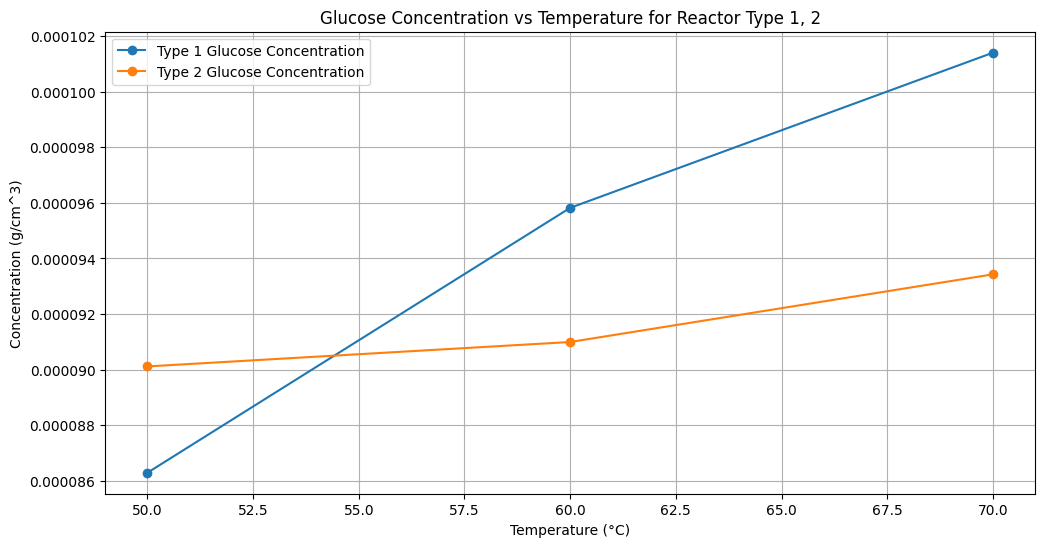

In [195]:
plt.figure(figsize=(12,6))
plt.plot(df_recent.query("Type == 1")["Temperature"], df_recent.query("Type == 1")["Glucose concentration (mol/L)"], label = "Type 1 Glucose Concentration", marker= "o")
plt.plot(df_recent.query("Type == 2")["Temperature"], df_recent.query("Type == 2")["Glucose concentration (mol/L)"], label = "Type 2 Glucose Concentration", marker= "o")
plt.xlabel("Temperature (°C)")
plt.ylabel("Concentration (g/cm^3)")
plt.title("Glucose Concentration vs Temperature for Reactor Type 1, 2")
plt.legend()
plt.grid()

plt.show()

##### Now using our surcose feed concentration, we can determine steady state conversion:
##### $$C_{\text{glucose}} = C_{\text{sucrose},0} \cdot X$$
##### $$X = \frac{C_{\text{glucose}}}{C_{\text{sucrose},i}}$$


In [196]:
C_sucrose_i = 7.6 * (1/1000) # g/cm^3
df_recent["Conversion"] = df_recent["Glucose concentration (mol/L)"] / C_sucrose_i

In [197]:
df_recent

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (mol/L),Conversion
0,2,1,1,50,1.5791,3,1.45350,0.000086,0.011354
1,5,1,1,60,1.7396,3,1.61400,0.000096,0.012608
2,8,1,1,70,1.8336,3,1.70800,0.000101,0.013342
3,11,2,2,50,1.6542,3,1.51791,0.000090,0.011857
4,14,2,2,60,1.6690,3,1.53271,0.000091,0.011973
5,17,2,2,70,1.7100,3,1.57371,0.000093,0.012293


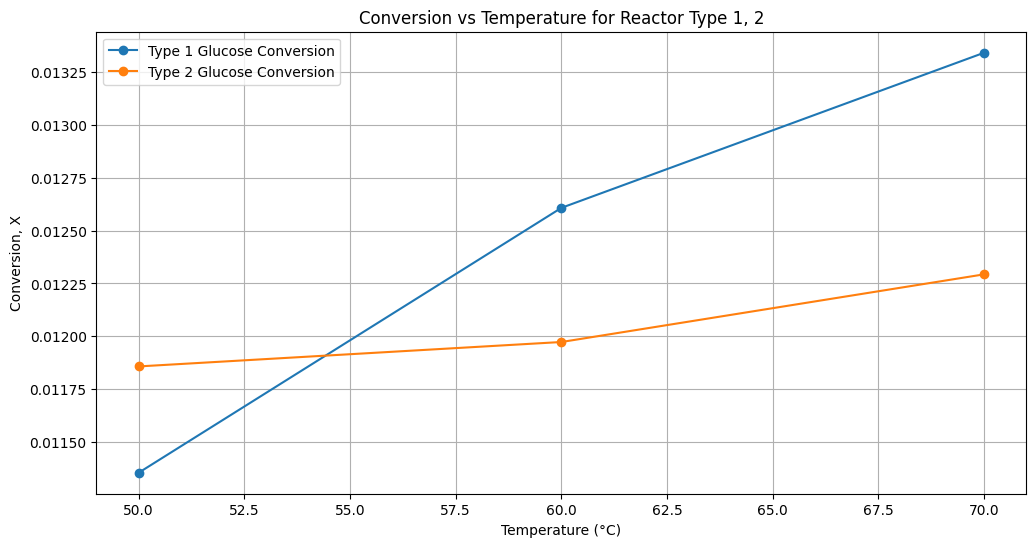

In [198]:
plt.figure(figsize=(12,6))
plt.plot(df_recent.query("Type == 1")["Temperature"], df_recent.query("Type == 1")["Conversion"], label = "Type 1 Glucose Conversion", marker= "o")
plt.plot(df_recent.query("Type == 2")["Temperature"], df_recent.query("Type == 2")["Conversion"], label = "Type 2 Glucose Conversion", marker= "o")
plt.xlabel("Temperature (°C)")
plt.ylabel("Conversion, X")
plt.title("Conversion vs Temperature for Reactor Type 1, 2")
plt.legend()
plt.grid()

plt.show()

### Solving for rate constant, k and diffusion coefficient, D

##### Starting wit k, our goal here is to use the relationship between conversion and k to solve:
##### $$\ln(1 - X) = -\frac{k \cdot (1 - \epsilon) \cdot L}{\text{velocity}}$$
##### $$k = -\frac{\ln(1 - X) \cdot \text{velocity}}{(1 - \epsilon) \cdot L}$$


In [242]:
r1 =  (0.52 * .1) / 2 # Particle radius for smaller diameter resin (cm)
r2 = (1.1 * .1) / 2 # Particle radius for larger diameter resin (cm)
epsilon1 = 0.40  # Void fraction for smaller UPDATE WITH ERROR
epsilon2 = 0.38  # Void fraction for larger UPDATE WITH ERROR
L = 25.0 # cm
area = np.pi * (1.25 ** 2)
volume = L * area
flow = 10 # ml/min = cm^3/min
velocity = 10 / area # ml/min = cm^3/min /A = cm / min
tau = volume / flow # min

0.026000000000000002 0.05500000000000001


In [200]:
df_recent.loc[df_recent["Type"] == 1, "Rate constant (k)"] = (
    -np.log(1 - df_recent.loc[df_recent["Type"] == 1, "Conversion"]) * velocity
    / ((1 - epsilon1) * L)
)

df_recent.loc[df_recent["Type"] == 2, "Rate constant (k)"] = (
    -np.log(1 - df_recent.loc[df_recent["Type"] == 2, "Conversion"]) * velocity
    / ((1 - epsilon2) * L)
)

df_recent


,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (mol/L),Conversion,Rate constant (k)
0,2,1,1,50,1.5791,3,1.45350,0.000086,0.011354,0.001551
1,5,1,1,60,1.7396,3,1.61400,0.000096,0.012608,0.001723
2,8,1,1,70,1.8336,3,1.70800,0.000101,0.013342,0.001824
3,11,2,2,50,1.6542,3,1.51791,0.000090,0.011857,0.001568
4,14,2,2,60,1.6690,3,1.53271,0.000091,0.011973,0.001583
5,17,2,2,70,1.7100,3,1.57371,0.000093,0.012293,0.001626


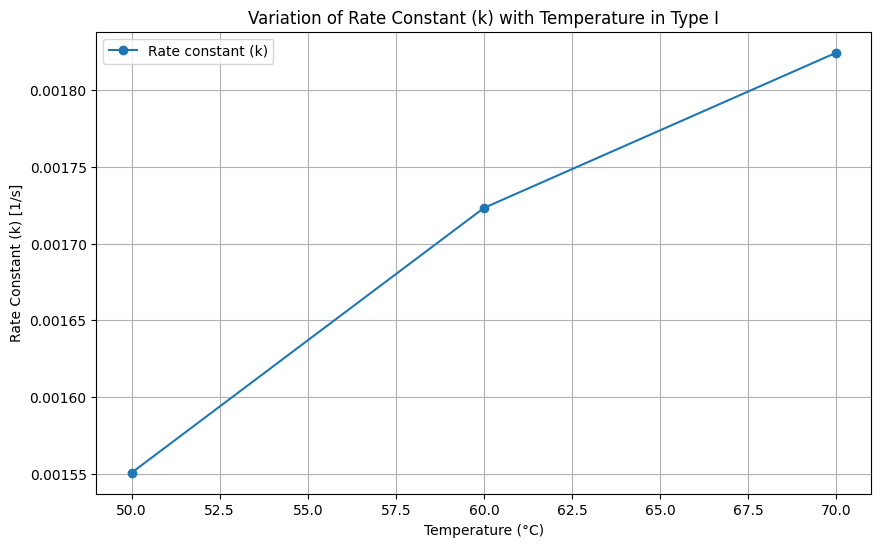

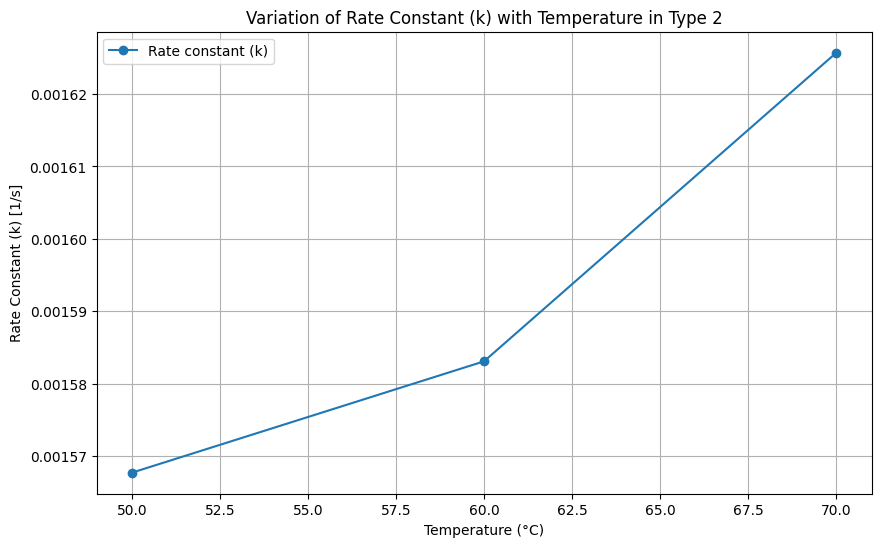

In [201]:
plt.figure(figsize=(10, 6))
plt.plot(df_recent.query("Type == 1")["Temperature"], df_recent.query("Type == 1")["Rate constant (k)"], marker='o', label="Rate constant (k)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Rate Constant (k) [1/s]")
plt.title("Variation of Rate Constant (k) with Temperature in Type I")
plt.grid()
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(df_recent.query("Type == 2")["Temperature"], df_recent.query("Type == 2")["Rate constant (k)"], marker='o', label="Rate constant (k)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Rate Constant (k) [1/s]")
plt.title("Variation of Rate Constant (k) with Temperature in Type 2")
plt.grid()
plt.legend()
plt.show()

##### Now, let's do Diffusivity

In [202]:
# def diffusivity_and_k(X1, X2, epsilon1, epsilon2, R1, R2, p):
#     numerator = (1 - epsilon1) * R2**2 * (R1 * p * np.cosh(R1 * p) / np.sinh(R1 * p) - 1)
#     denominator = (1 - epsilon2) * R1**2 * (R2 * p * np.cosh(R2 * p) / np.sinh(R2 * p) - 1)
#     return np.log(1 - X1) / np.log(1 - X2) - numerator / denominator

# def p(k, De):
#     return np.sqrt(k / De)

In [236]:
df_1 = df_recent.query("Type == 1")
df_2 = df_recent.query("Type == 2")

df_merged = pd.merge(df_1, df_2, on=["Temperature"], suffixes=('_1', '_2'))
df_merged["ln_ratio"] = np.log(1 - df_merged["Conversion_1"]) / np.log(1 - df_merged["Conversion_2"])

In [237]:
df_merged

,index_1,Day_1,Type_1,Temperature,Absorbance_1,Sample_1,Absorbance adjusted_1,Glucose concentration (mol/L)_1,Conversion_1,Rate constant (k)_1,index_2,Day_2,Type_2,Absorbance_2,Sample_2,Absorbance adjusted_2,Glucose concentration (mol/L)_2,Conversion_2,Rate constant (k)_2,ln_ratio
0,2,1,1,50,1.5791,3,1.4535,0.000086,0.011354,0.001551,11,2,2,1.6542,3,1.51791,0.000090,0.011857,0.001568,0.957323
1,5,1,1,60,1.7396,3,1.6140,0.000096,0.012608,0.001723,14,2,2,1.6690,3,1.53271,0.000091,0.011973,0.001583,1.053375
2,8,1,1,70,1.8336,3,1.7080,0.000101,0.013342,0.001824,17,2,2,1.7100,3,1.57371,0.000093,0.012293,0.001626,1.085909


In [244]:
X1 = df_recent.query("Type == 1")["Conversion"].reset_index(drop=True)
X2 = df_recent.query("Type == 2")["Conversion"].reset_index(drop=True)
k_values = df_recent.query("Type == 1")["Rate constant (k)"].reset_index(drop=True)

if len(X1) != len(X2):
    raise ValueError("Lengths of X1 and X2 must match.")

results = []

for i in range(len(X1)):
    x1 = X1.iloc[i]
    x2 = X2.iloc[i]
    k = k_values.iloc[i]

    lhs = np.log(1 - x1) / np.log(1 - x2)
    rhs_multiplier = ((1 - epsilon1) * r2**2) / ((1 - epsilon2) * r1**2)

    def equation(p):
        term1 = r1 * p * (1 / np.tanh(r1 * p)) - 1
        term2 = r2 * p * (1 / np.tanh(r2 * p)) - 1
        return lhs - rhs_multiplier * (term1 / term2)

    p_min, p_max = 1e-5, 10000.0
    f_p_min = equation(p_min)
    f_p_max = equation(p_max)

    if f_p_min * f_p_max > 0:
        print(f"No root found for X1={x1}, X2={x2} in the given range.")
        results.append((x1, x2, k, None, None))
    else:
        result = root_scalar(equation, bracket=(p_min, p_max), method='brentq')

        if result.converged:
            p = result.root
            De = k / p**2
            results.append((x1, x2, k, p, De))
        else:
            print(f"Failed to find a solution for X1={x1}, X2={x2}.")
            results.append((x1, x2, k, None, None))

results_df = pd.DataFrame(results, columns=["X1", "X2", "k", "p", "De"])
print(results_df)

No root found for X1=0.011354050972020552, X2=0.011857191269996363 in the given range.
         X1        X2         k          p        De
0  0.011354  0.011857  0.001551        NaN       NaN
1  0.012608  0.011973  0.001723  24.854643  0.000003
2  0.013342  0.012293  0.001824  29.729246  0.000002


In [222]:
df_recent["Rate constant (k)"].iloc[0] / (f_p_min** 2)

np.float64(6.365486923243544)